## Pointwise Mutual Information
The current network is really dense. This suggests some type of edge filtering could be useful to make the network smaller and get better results.

Pointwise Mutual Information is calculated as
$$
\text{pmi}(x; y) = \log \frac{p(x, y)}{p(x)p(y)}
$$
where $p(x)$ is the probability of event $x$ occurring and $p(x, y)$ is the probability of both events $x$ and $y$ occurring at the same time. The functions all have support for different $k$s in $\text{pmi}^k$ where
$$
\text{pmi}^k(x; y) = \log \frac{p(x, y)^k}{p(x)p(y)}.
$$

#### Preliminaries

In [37]:
# load some packages
import Gavin.utils.make_network as mn # updated make network that supports edge filtering
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# config
DATA_PATH = 'datasets/concept_network/'
# CONCEPT_FILE = 'articles_category_for_2l_abstracts_concepts_processed_v1_EX_102.csv.gz' # Applied Mathematics
# CONCEPT_FILE = 'concepts_Applied Economics_1402.csv.gz' # Applied Econ
CONCEPT_FILE = 'concepts_Zoology_608.csv' # Zoology
article_concept_df = mn.filter_article_concept_file(
        DATA_PATH+CONCEPT_FILE,
        min_relevance=0.7,
        min_year=1920,
        min_articles=3, # require each concept to show up more than once
        normalize_year=True
    )
K = 1

#### Get PMI
The `filter_cooccurrences` function lets you use keywords to only include edges within a range of cooccurrences and above a certain PMI, but without those keywords, it just creates an edgelist dataframe with columns for each of the probabilities and PMI. There also is a `k` argument that lets you find alternate PMIs

In [38]:
concept_pairs_df = mn.filter_cooccurrences(article_concept_df, k=K)

#### PMI Distribution
We see that the PMI distribution has a left tail, with some weird noise to the right. I believe this is caused by low probability concepts having a higher PMI.

<Axes: >

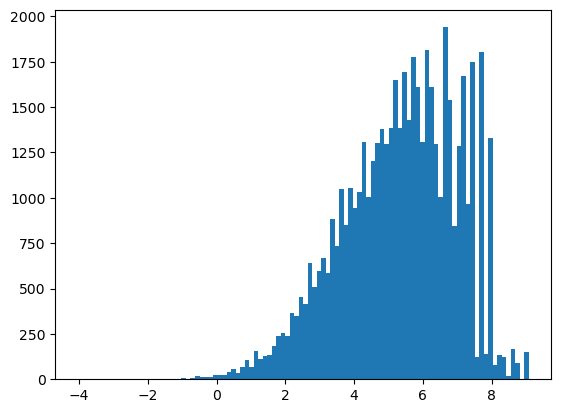

In [40]:
concept_pairs_df[f'pmi^{K}'].hist(bins=100, grid=False)

#### Network Properties
Look at the number of nodes, edges, and the average degree for a number of PMI threshholds.

Notice the average degree and number of edges decreases much faster than the number of nodes. This suggests that PMI filtering along doesn't create a workable network, and some concept filtering to get a more manageable number of nodes in the network is likely needed.

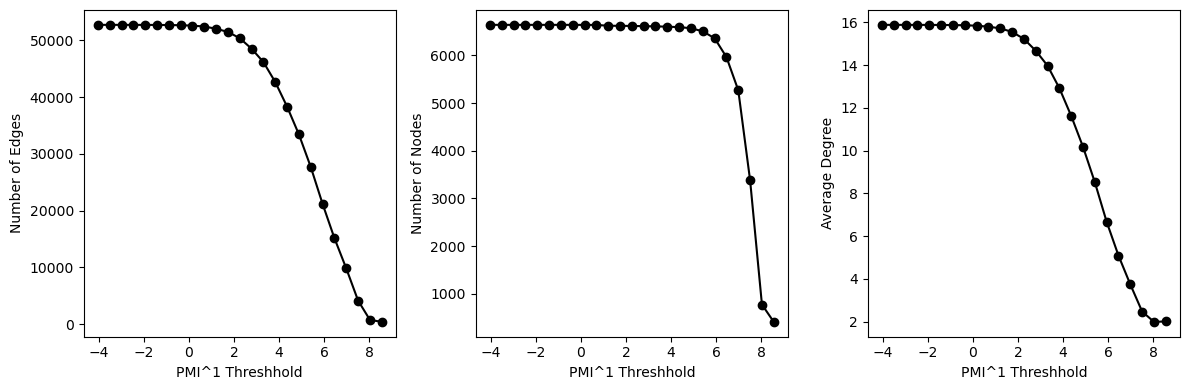

In [41]:
# helper functions
def num_edges(pairs_df):
    return len(pairs_df)

def num_nodes(pairs_df):
    return pd.concat((pairs_df['concept_s'], pairs_df['concept_t'])).nunique()

def avg_degree(num_edges, num_nodes):
    return num_edges*2/num_nodes

# setup
n = 25
df = pd.DataFrame(columns=['thresh', 'num_edges', 'num_nodes', 'avg_degree'])
df['thresh'] = np.linspace(concept_pairs_df[f'pmi^{K}'].min(), concept_pairs_df[f'pmi^{K}'].max(), n, endpoint=False)

# figure out network stats
for i, t in enumerate(df['thresh']):
    filtered_concept_pairs_df = concept_pairs_df[concept_pairs_df[f'pmi^{K}'] >= t]

    df.loc[i, 'num_edges'] = num_edges(filtered_concept_pairs_df)
    df.loc[i, 'num_nodes'] = num_nodes(filtered_concept_pairs_df)
    df.loc[i, 'avg_degree'] = avg_degree(df.loc[i, 'num_edges'], df.loc[i, 'num_nodes'])
    
# plot setup
fig, axs = plt.subplots(1, 3)
fig.set_figheight(4)
fig.set_figwidth(12)
axs[0].set_ylabel('Number of Edges')
axs[1].set_ylabel('Number of Nodes')
axs[2].set_ylabel('Average Degree')
for ax in axs:
    ax.set_xlabel(f'PMI^{K} Threshhold')

# plot data
axs[0].plot(df['thresh'], df['num_edges'], 'ko-')
axs[1].plot(df['thresh'], df['num_nodes'], 'ko-')
axs[2].plot(df['thresh'], df['avg_degree'], 'ko-')

# plot formatting
fig.tight_layout()